In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Combined_QB.csv')  # Replace with your actual data
metric = 'Current_PFF'  # Specify the metric you want to predict

In [3]:
print(df.columns)

Index(['Unnamed: 0', 'Team', 'Year', 'Position', 'Value_cap_space',
       'Value_draft_data', 'Previous_AV', 'Current_AV', 'Previous_PFF',
       'Current_PFF', 'Total DVOA', 'win-loss-pct', 'Net EPA',
       'weighted_avg_accuracy_percent', 'weighted_avg_aimed_passes',
       'weighted_avg_attempts', 'weighted_avg_avg_depth_of_target',
       'weighted_avg_avg_time_to_throw', 'weighted_avg_bats',
       'weighted_avg_big_time_throws', 'weighted_avg_btt_rate',
       'weighted_avg_completion_percent', 'weighted_avg_completions',
       'weighted_avg_declined_penalties', 'weighted_avg_def_gen_pressures',
       'weighted_avg_drop_rate', 'weighted_avg_dropbacks',
       'weighted_avg_drops', 'weighted_avg_first_downs',
       'weighted_avg_franchise_id', 'weighted_avg_grades_hands_fumble',
       'weighted_avg_grades_pass', 'weighted_avg_grades_run',
       'weighted_avg_hit_as_threw', 'weighted_avg_interceptions',
       'weighted_avg_passing_snaps', 'weighted_avg_penalties',
       'w

In [4]:
columns_to_drop = ['Unnamed: 0']
df = df.drop(columns=columns_to_drop)


In [5]:
df = df.sort_values(by=['Team', 'Year'])

# Display the sorted data
print(df.head())


      Team  Year Position  Value_cap_space  Value_draft_data  Previous_AV  \
17   49ers  2019       QB        11.439957         24.060673         11.0   
50   49ers  2020       QB         0.610494         34.317120         15.0   
70   49ers  2021       QB        17.863014        528.923536         11.0   
123  49ers  2022       QB         6.959654        412.212335         15.0   
12   Bears  2019       QB         7.396387        434.985593         15.0   

     Current_AV  Previous_PFF  Current_PFF Total DVOA  ...  \
17         15.0     64.331406    77.900000     27.90%  ...   
50         11.0     77.900000    61.558114      5.40%  ...   
70         15.0     61.558114    72.551515     19.50%  ...   
123        17.0     72.551515    71.909475     27.60%  ...   
12          9.0     62.198104    64.653902     -2.10%  ...   

     Previous_sack_percent  Previous_sacks  Previous_scrambles  \
17                8.019063       16.592188            4.965625   
50                6.800000      

In [6]:
team_data = df.groupby('Team')
print(team_data.head)


<bound method GroupBy.head of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x3006520c0>>


In [7]:
import numpy as np

sequences = []
targets = []

# Iterate over each team and its respective data
for team, group in team_data:
    # Ensure the team has at least 4 years of data
    if len(group) >= 4:
        print(f"Processing team: {team}, data length: {len(group)}")  # Debugging: check length of data for each team
        
        # Iterate through the data to create sequences for 3 years
        for i in range(len(group) - 3):
            # Select the relevant columns for the sequence
            sequence = group.iloc[i:i+3][['Previous_twp_rate', 'Value_cap_space', 'Previous_AV', 'Previous_PFF', 
                                           'Previous_ypa', 'Previous_qb_rating', 'Previous_grades_pass', 
                                           'Previous_accuracy_percent', 'Previous_btt_rate']]  # Add more columns if needed
            
            # The target is the next year's Current_PFF
            target = group.iloc[i+3]['Current_PFF']  
            
            sequences.append(sequence.values)  # Add the sequence to the list
            targets.append(target)  # Add the target to the list

# Convert lists to numpy arrays
X = np.array(sequences)
y = np.array(targets)



print(f"Total sequences generated: {len(sequences)}")
print(f"X shape: {X.shape}, y shape: {y.shape}")


Processing team: 49ers, data length: 4
Processing team: Bears, data length: 4
Processing team: Bengals, data length: 4
Processing team: Bills, data length: 4
Processing team: Broncos, data length: 4
Processing team: Browns, data length: 4
Processing team: Buccaneers, data length: 4
Processing team: Cardinals, data length: 4
Processing team: Chargers, data length: 4
Processing team: Chiefs, data length: 4
Processing team: Colts, data length: 4
Processing team: Commanders, data length: 4
Processing team: Cowboys, data length: 4
Processing team: Dolphins, data length: 4
Processing team: Eagles, data length: 4
Processing team: Falcons, data length: 4
Processing team: Giants, data length: 4
Processing team: Jaguars, data length: 4
Processing team: Jets, data length: 4
Processing team: Lions, data length: 4
Processing team: Packers, data length: 4
Processing team: Panthers, data length: 4
Processing team: Patriots, data length: 4
Processing team: Raiders, data length: 4
Processing team: Rams

In [8]:
# Check shape before reshaping
print(X)
print(X.shape)

# Reshape X to (samples, timesteps, features)
X = X.reshape(X.shape[0], 3, -1)  # 3 years per sequence, features will be inferred

print(X.shape)  # Should now be (samples, 3, features)
print(X)

[[[  3.14234375  11.43995749  11.          64.33140625   7.97234375
    87.7428125   65.1784375   74.32578125   2.13875   ]
  [  3.4          0.61049445  15.          77.9          8.4
   102.          75.7         78.8          2.6       ]
  [  4.5137558   17.8630137   11.          61.55811437   7.5927357
    90.24605873  60.39690881  75.82952087   3.00850077]]

 [[  3.80300158   7.39638682  15.          62.19810427   7.31090047
    94.68720379  58.16319115  72.39494471   4.11879937]
  [  3.44566474   8.06760848   9.          64.65390173   6.17991329
    84.07037572  64.42196532  71.81921965   3.93973988]
  [  4.44748201   6.39452055  10.          64.11294964   6.37266187
    86.73453237  62.75971223  72.42374101   4.23309353]]

 [[  3.66574501   9.24017003  11.          71.89754224   6.5546851
    87.06513057  69.64009217  72.4          5.11213518]
  [  4.6108484    0.61049445   8.          60.80876217   6.41641168
    75.65215577  60.30166898  68.67232267   2.71043115]
  [  3.536950

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [10]:
# Define the input layer
inputs = Input(shape=(3, 9))  # 3 time steps, 8 features

# Add a Dense layer before the attention to create more variability in the input
dense_input = Dense(16, activation='relu')(inputs)

# Add MultiHeadAttention layer
attention_output = MultiHeadAttention(num_heads=2, key_dim=8)(dense_input, dense_input)

# Add Layer Normalization for stability
attention_output = LayerNormalization()(attention_output)

# Add RNN layer to capture temporal dependencies
rnn_output = SimpleRNN(units=50, activation='relu')(attention_output)

# Add Dropout to prevent overfitting
rnn_output = Dropout(0.2)(rnn_output)

# Output layer for predicting Current PFF
output = Dense(1)(rnn_output)

# Define the model
model = Model(inputs=inputs, outputs=output)


In [11]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [12]:
# Early stopping callback to monitor validation loss
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


Epoch 1/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 75.5649 - val_loss: 145.0705
Epoch 2/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.7187 - val_loss: 181.2228
Epoch 3/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 72.1271 - val_loss: 177.6974
Epoch 4/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 60.8498 - val_loss: 143.7284
Epoch 5/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 86.3031 - val_loss: 135.0109
Epoch 6/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 95.6823 - val_loss: 148.3405
Epoch 7/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47.8197 - val_loss: 182.9735
Epoch 8/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 84.5525 - val_loss: 147.1363
Epoch 9/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 140.5424 - val_loss: 137.9152
Epoch 10/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 110.2201 - val_loss: 137.2114
Epoch 11/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 126.0619 - val_loss: 143.7670
Epoch 12/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11

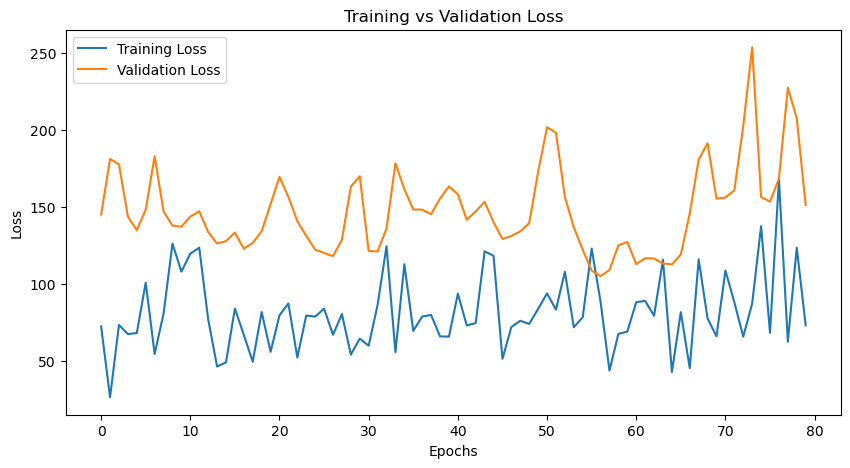

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
R² Score: 0.5513


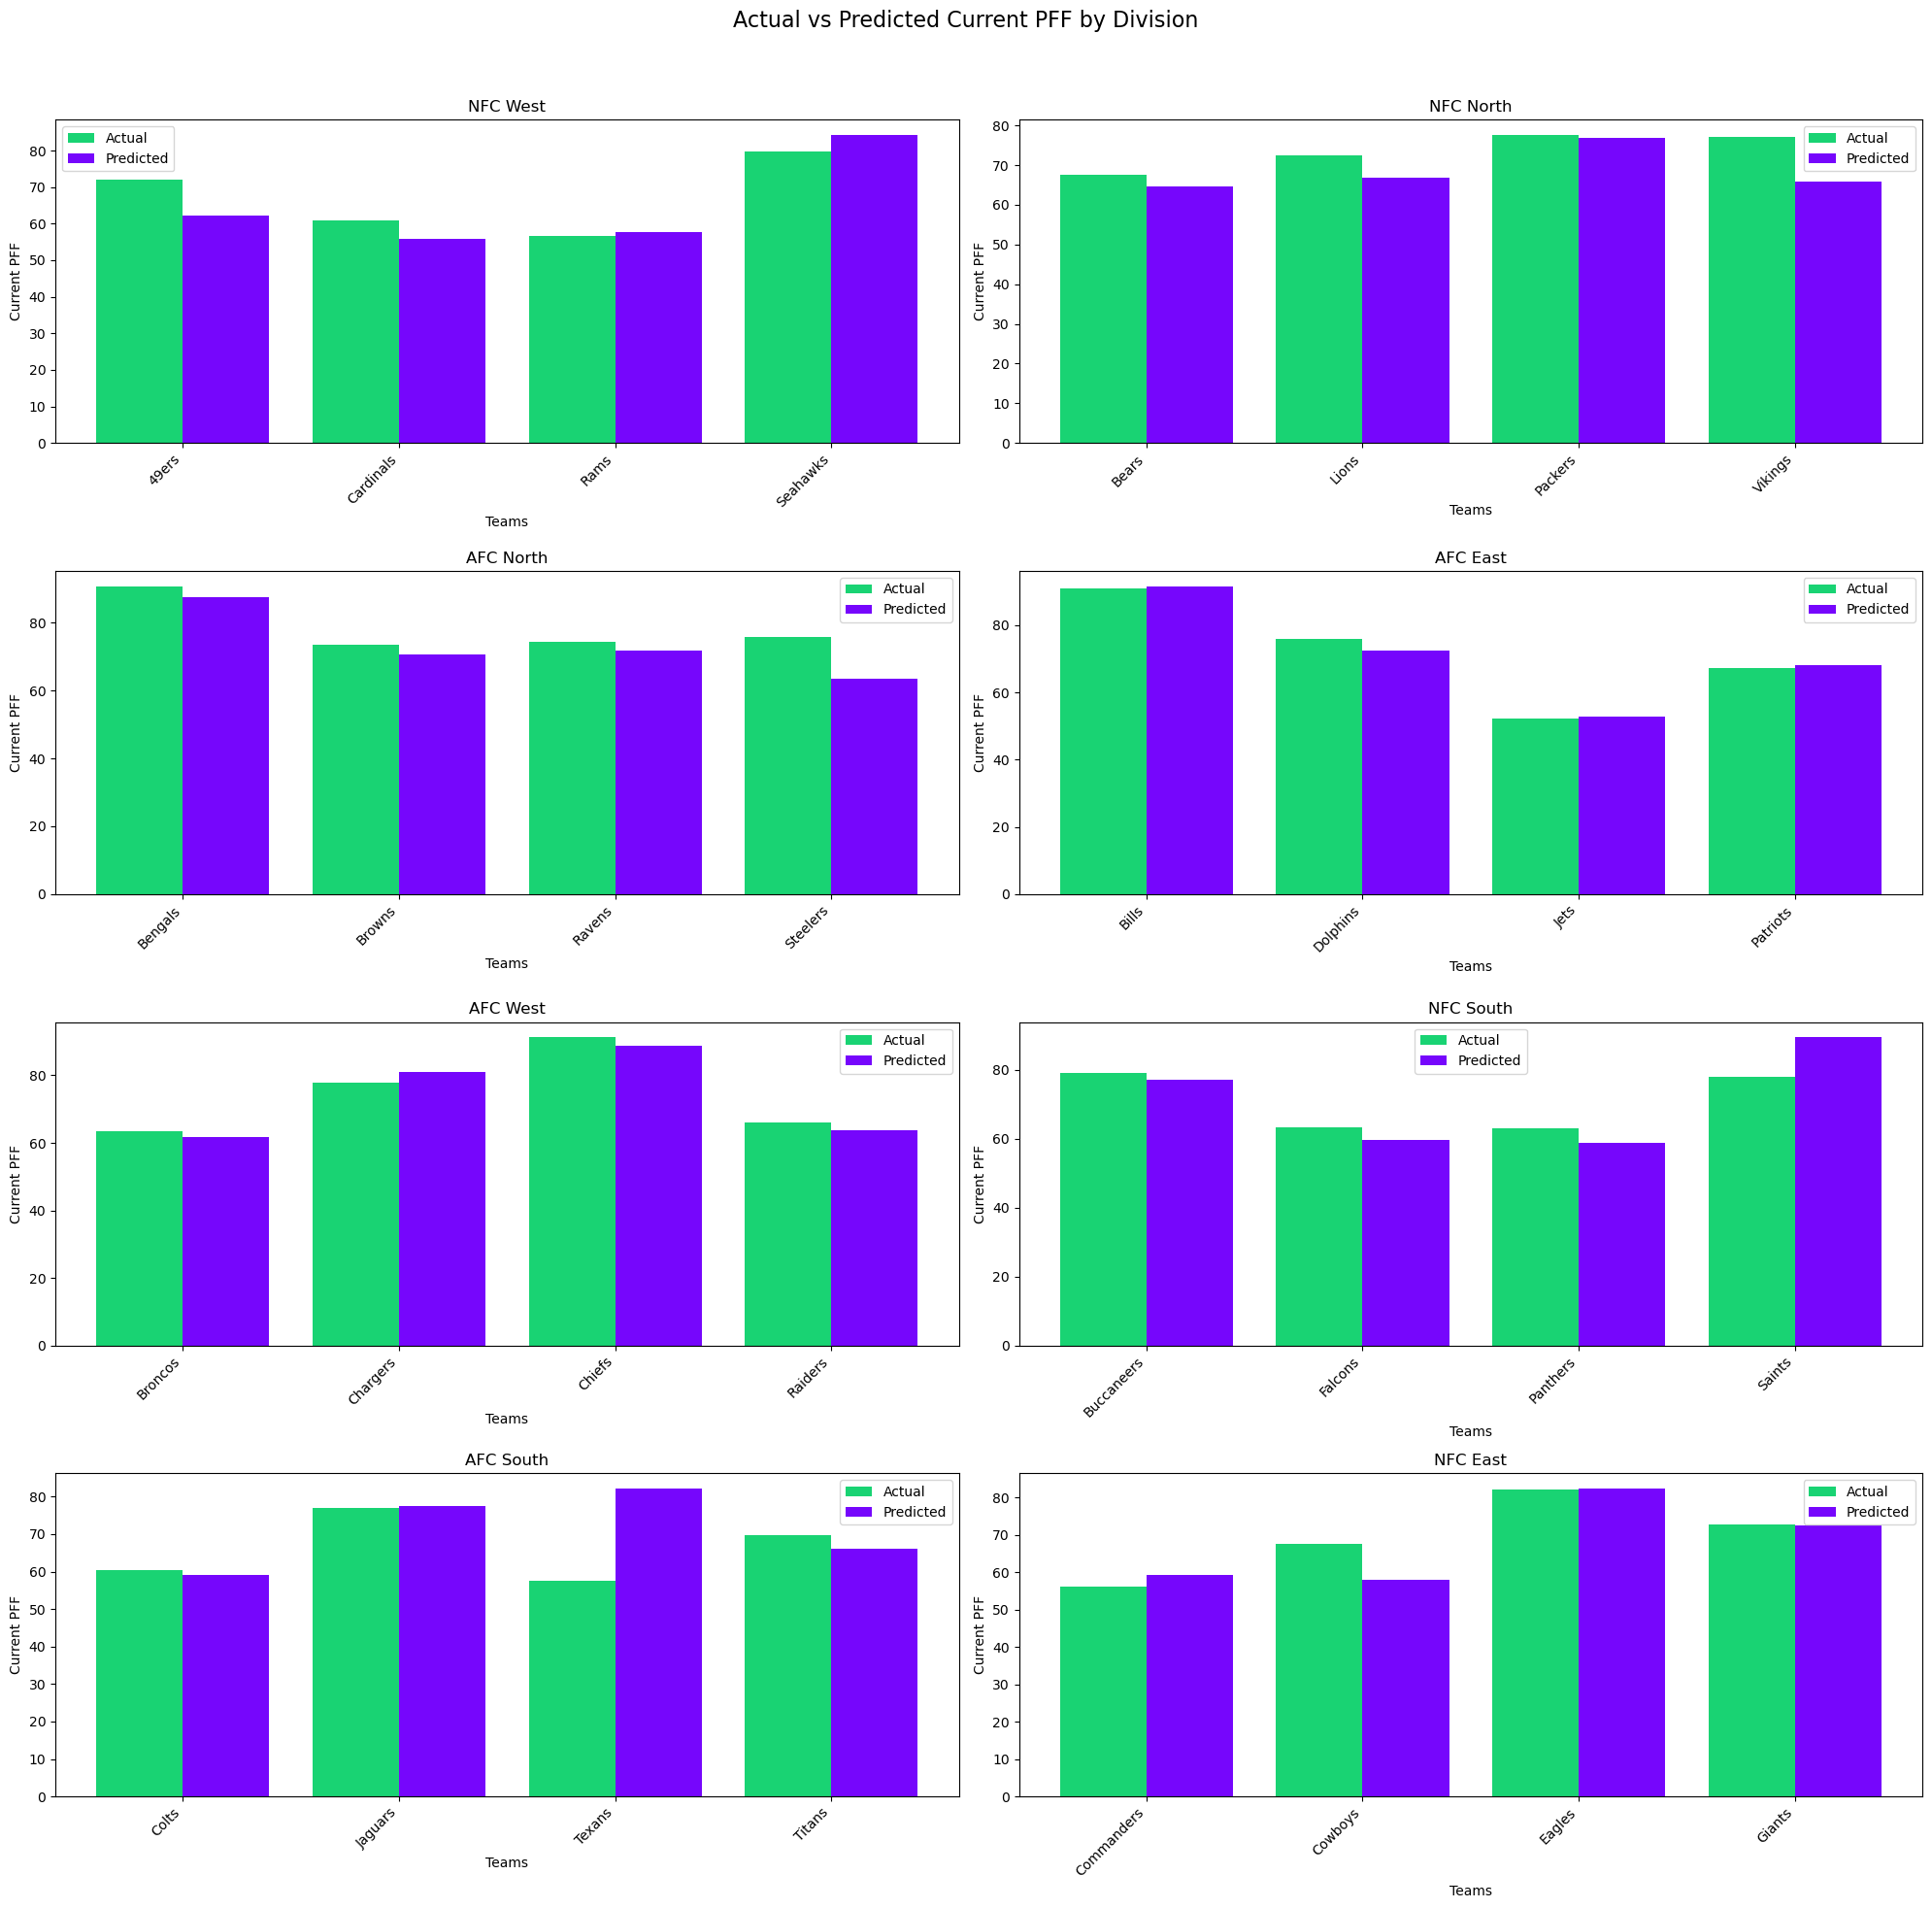

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 44.3187 - val_loss: 136.5106
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 43.2993 - val_loss: 131.2773
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 88.7960 - val_loss: 126.1200
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 81.8823 - val_loss: 126.5656
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 71.1260 - val_loss: 124.6209
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 66.5695 - val_loss: 135.5211
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 88.3360 - val_loss: 109.3315
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 65.7914 - val_loss: 101.1541
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 64.0473 - val_loss: 103.1004
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63.2039 - val_loss: 98.1869
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 87.4099 - val_loss: 98.1140
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

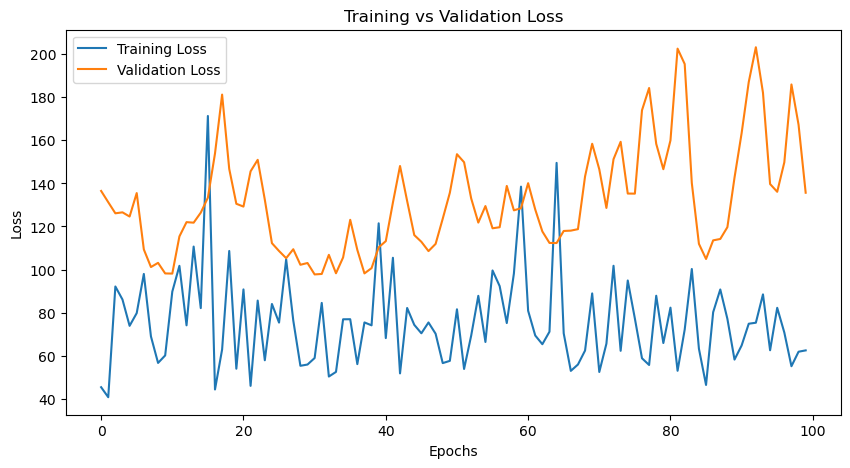

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
R² Score: 0.5526


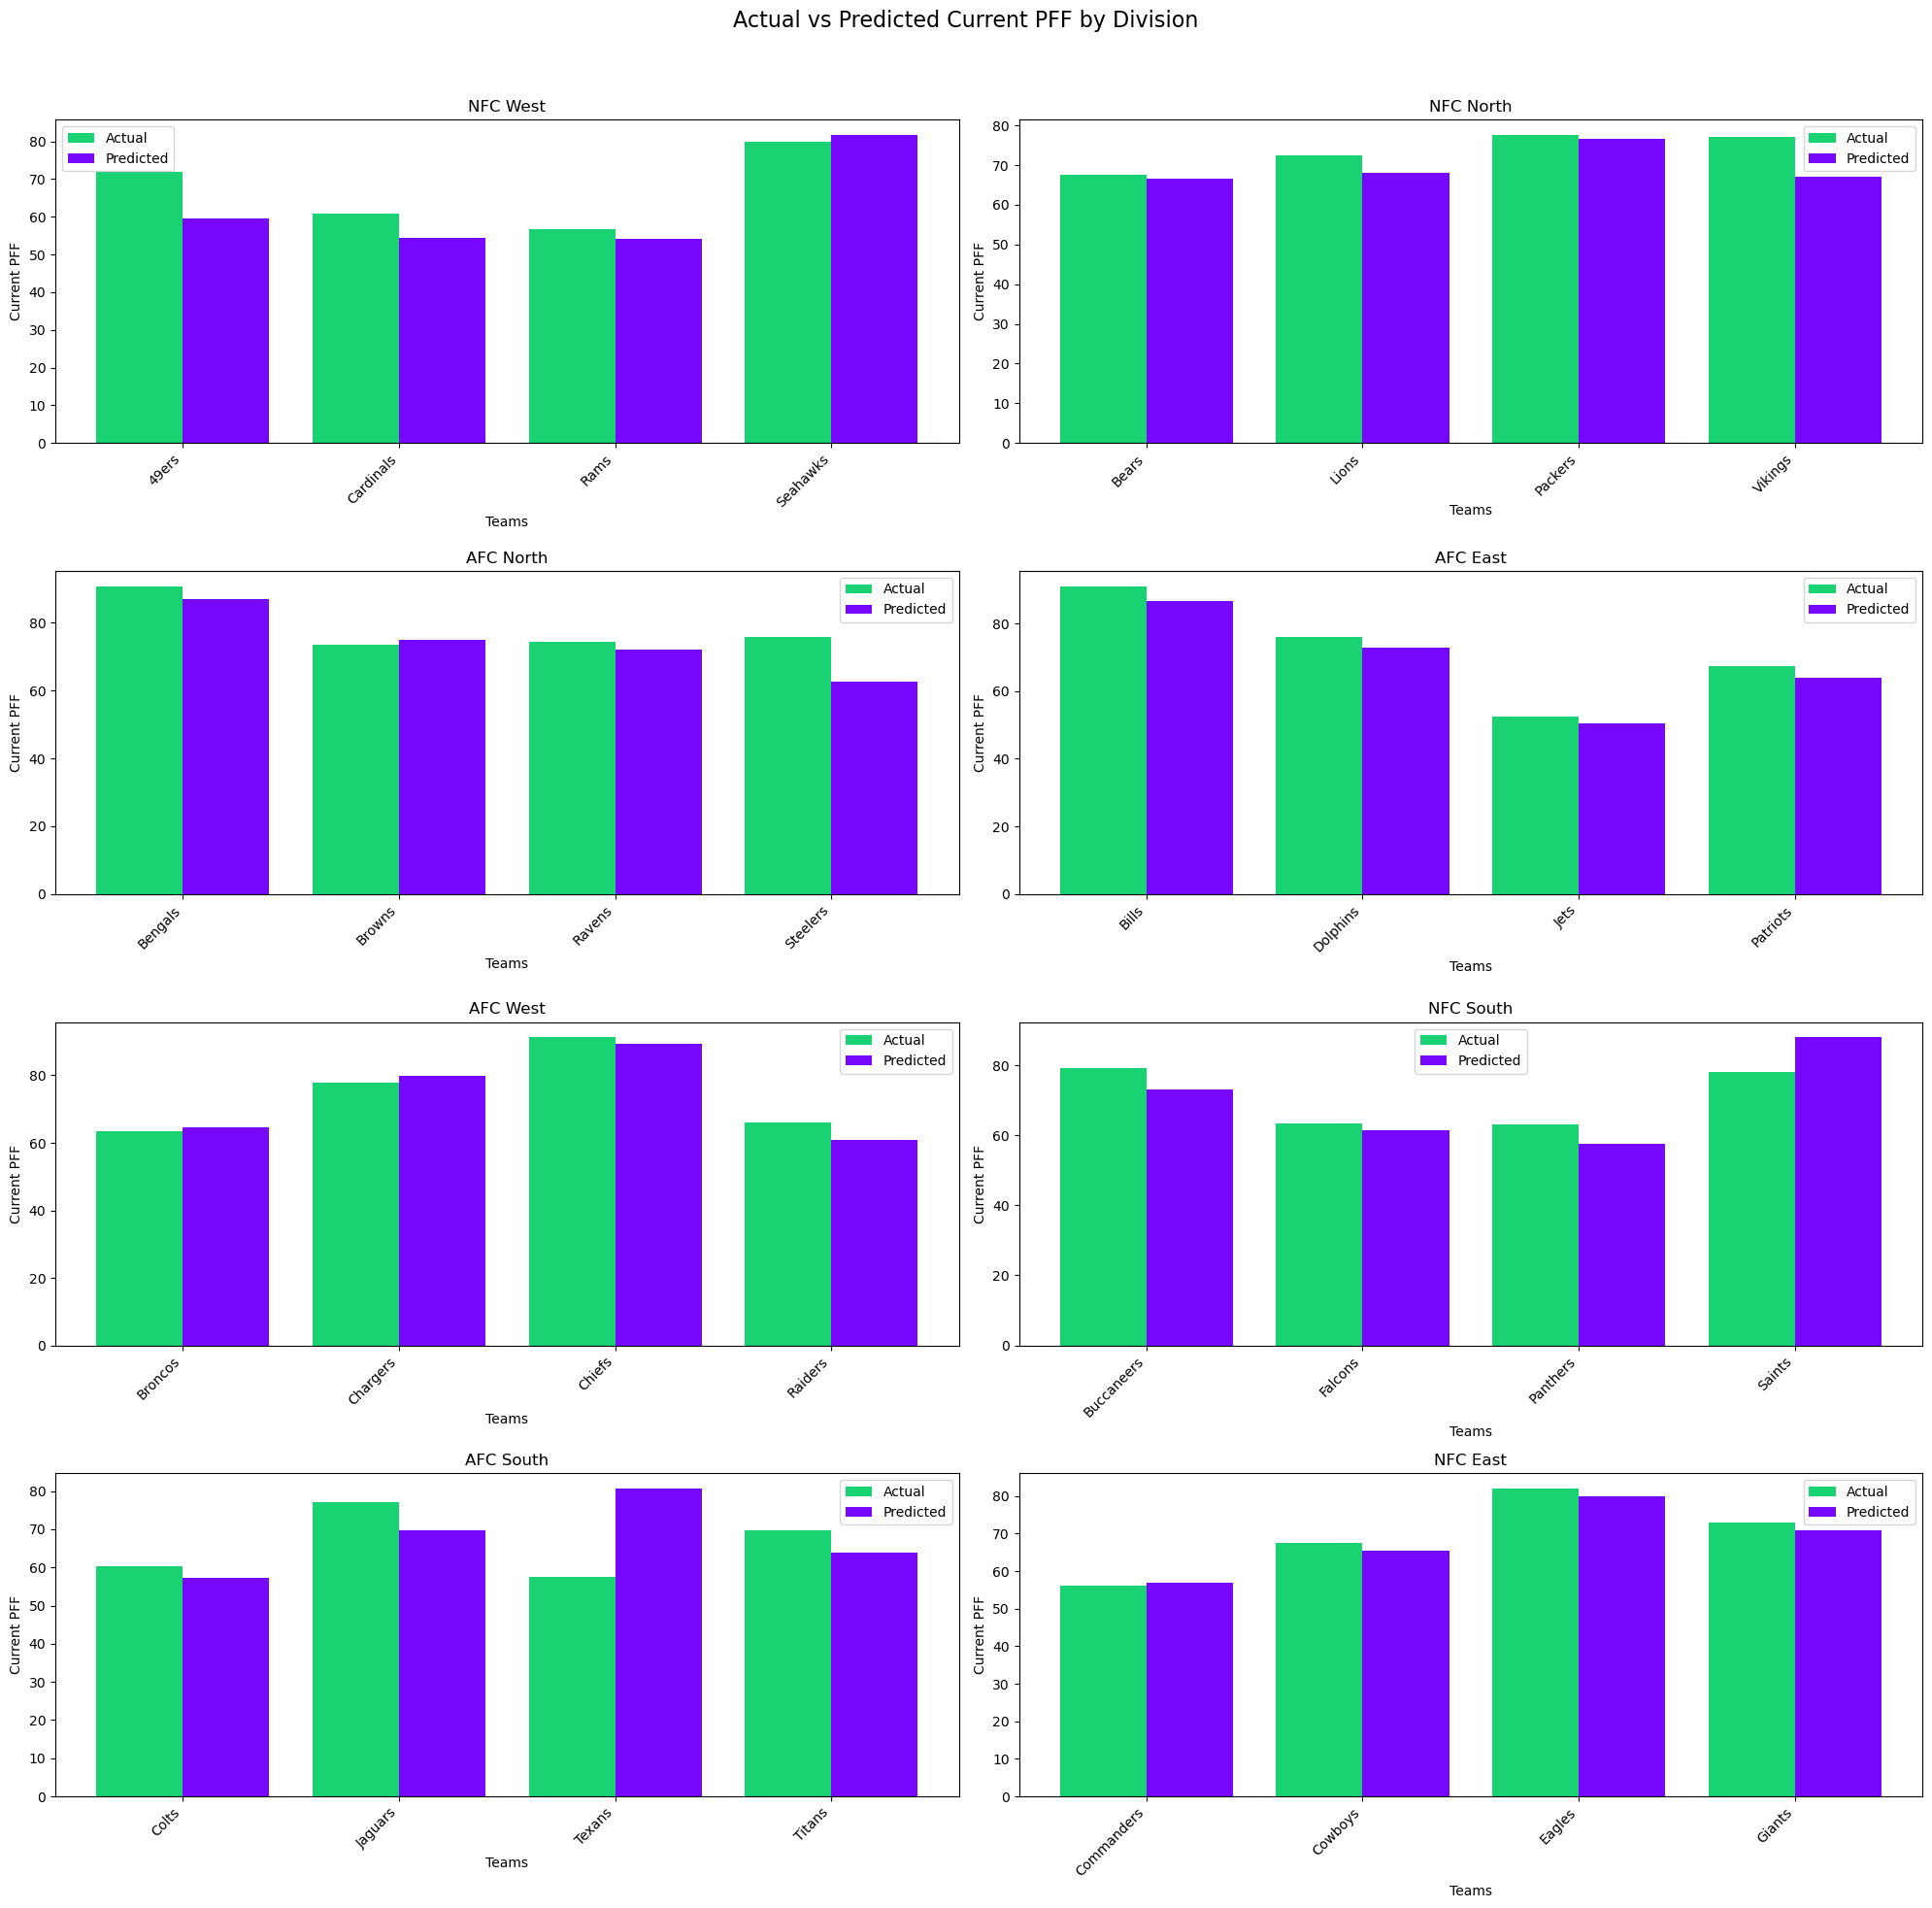

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 61.7369 - val_loss: 137.4584
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 95.9816 - val_loss: 129.8198
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 73.6924 - val_loss: 128.0636
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.9476 - val_loss: 122.7438
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51.2737 - val_loss: 127.5698
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 91.4932 - val_loss: 141.8609
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 43.5806 - val_loss: 156.2087
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 90.0551 - val_loss: 167.1005
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35.1307 - val_loss: 170.0334
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 78.2200 - val_loss: 169.6823
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 58.4952 - val_loss: 159.0640
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

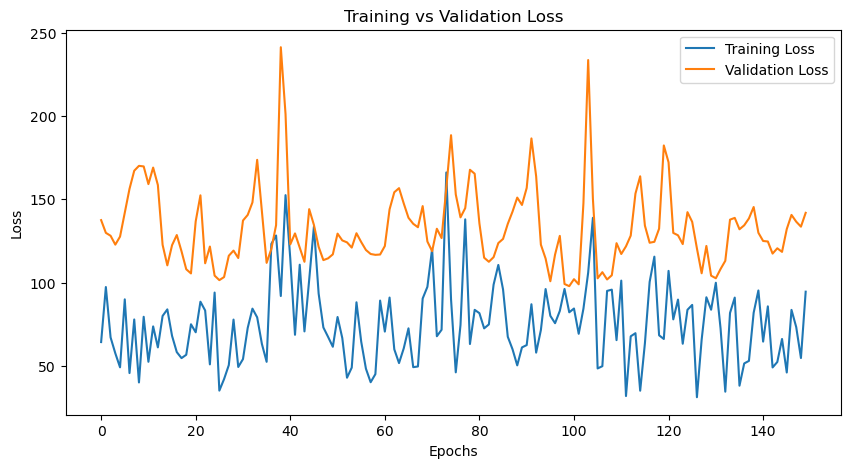

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
R² Score: 0.5304


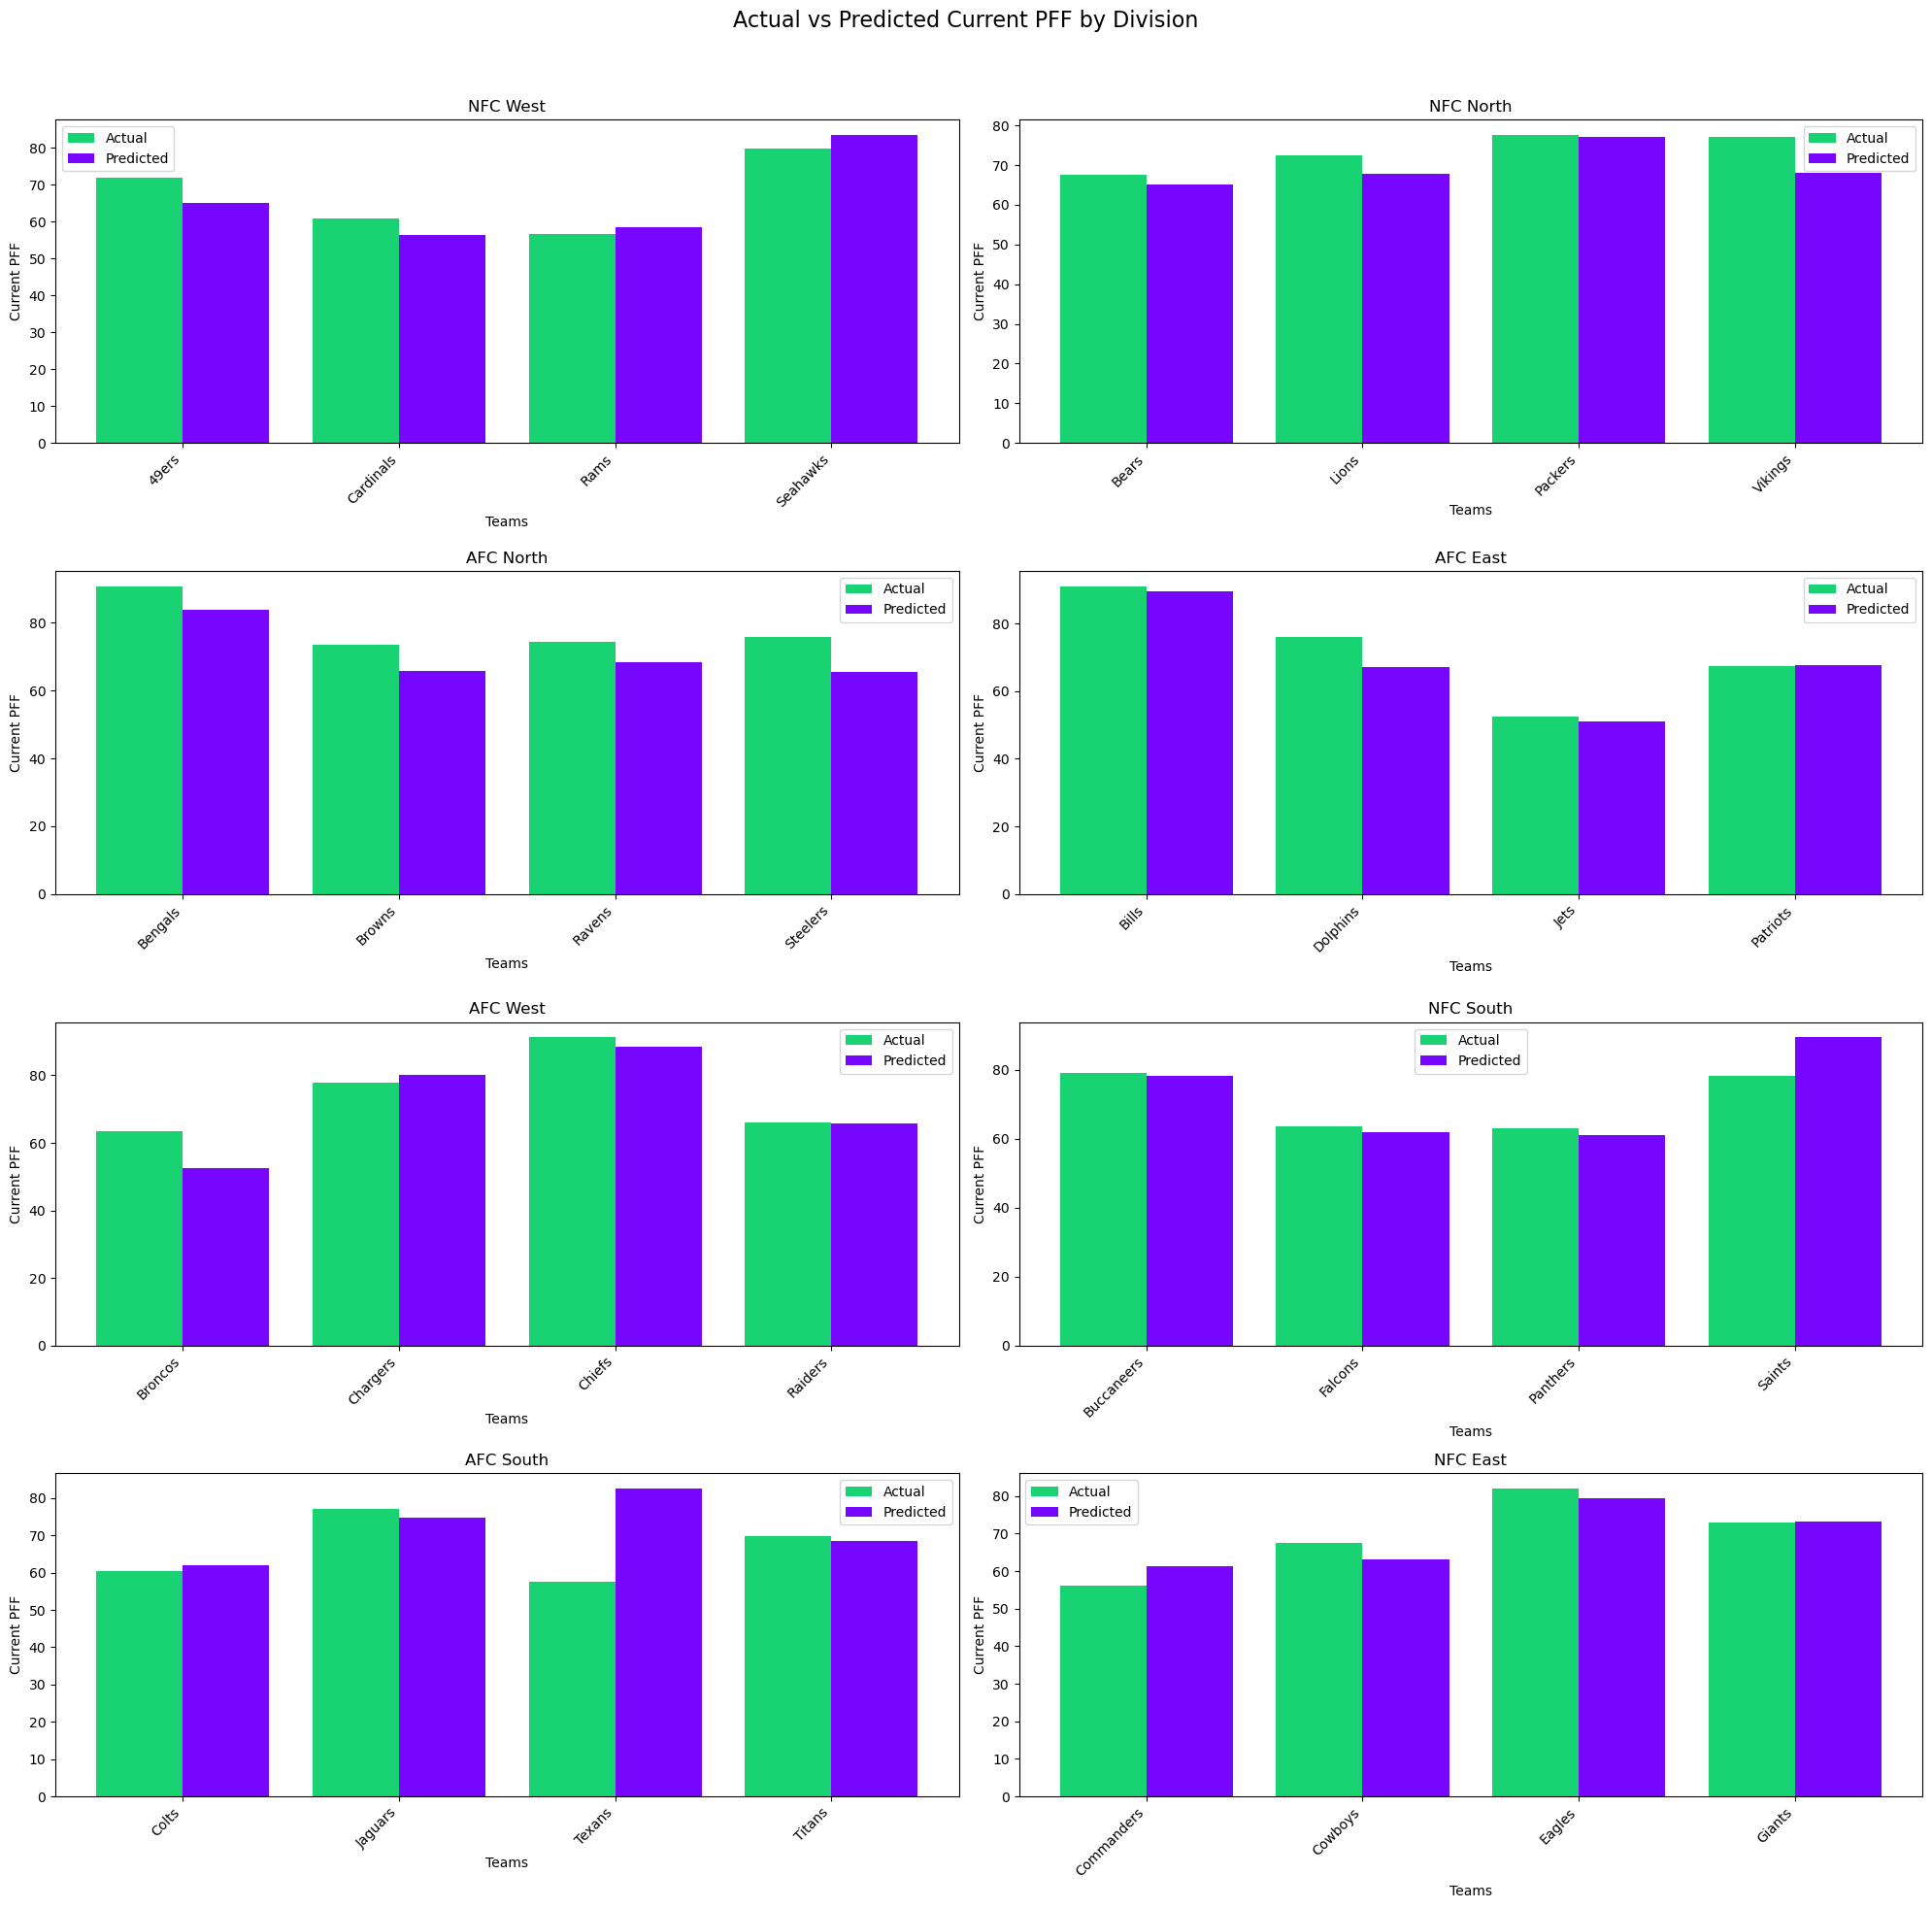

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 65.9901 - val_loss: 173.1537
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 62.3776 - val_loss: 167.9009
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 57.6315 - val_loss: 148.0787
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 140.1772 - val_loss: 149.0301
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 90.6508 - val_loss: 157.2088
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 94.7997 - val_loss: 142.1598
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 105.1192 - val_loss: 126.5206
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.3937 - val_loss: 119.2824
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 60.7622 - val_loss: 122.6956
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.1025 - val_loss: 125.8820
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.1176 - val_loss: 119.7495
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

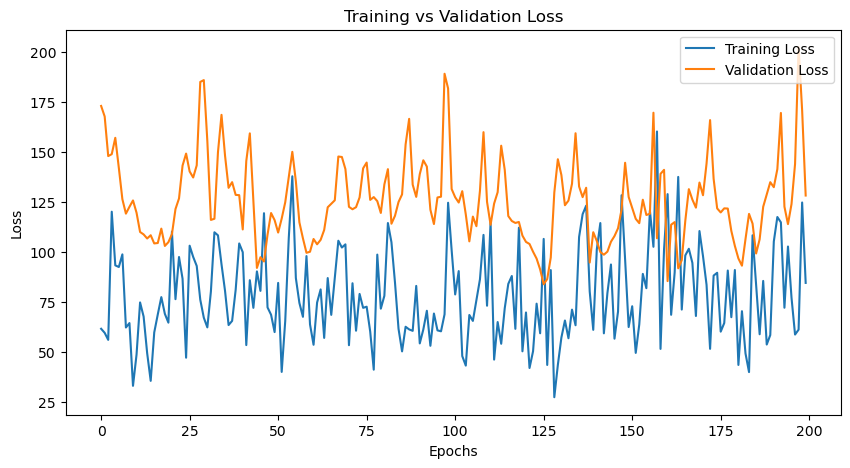

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
R² Score: 0.4791


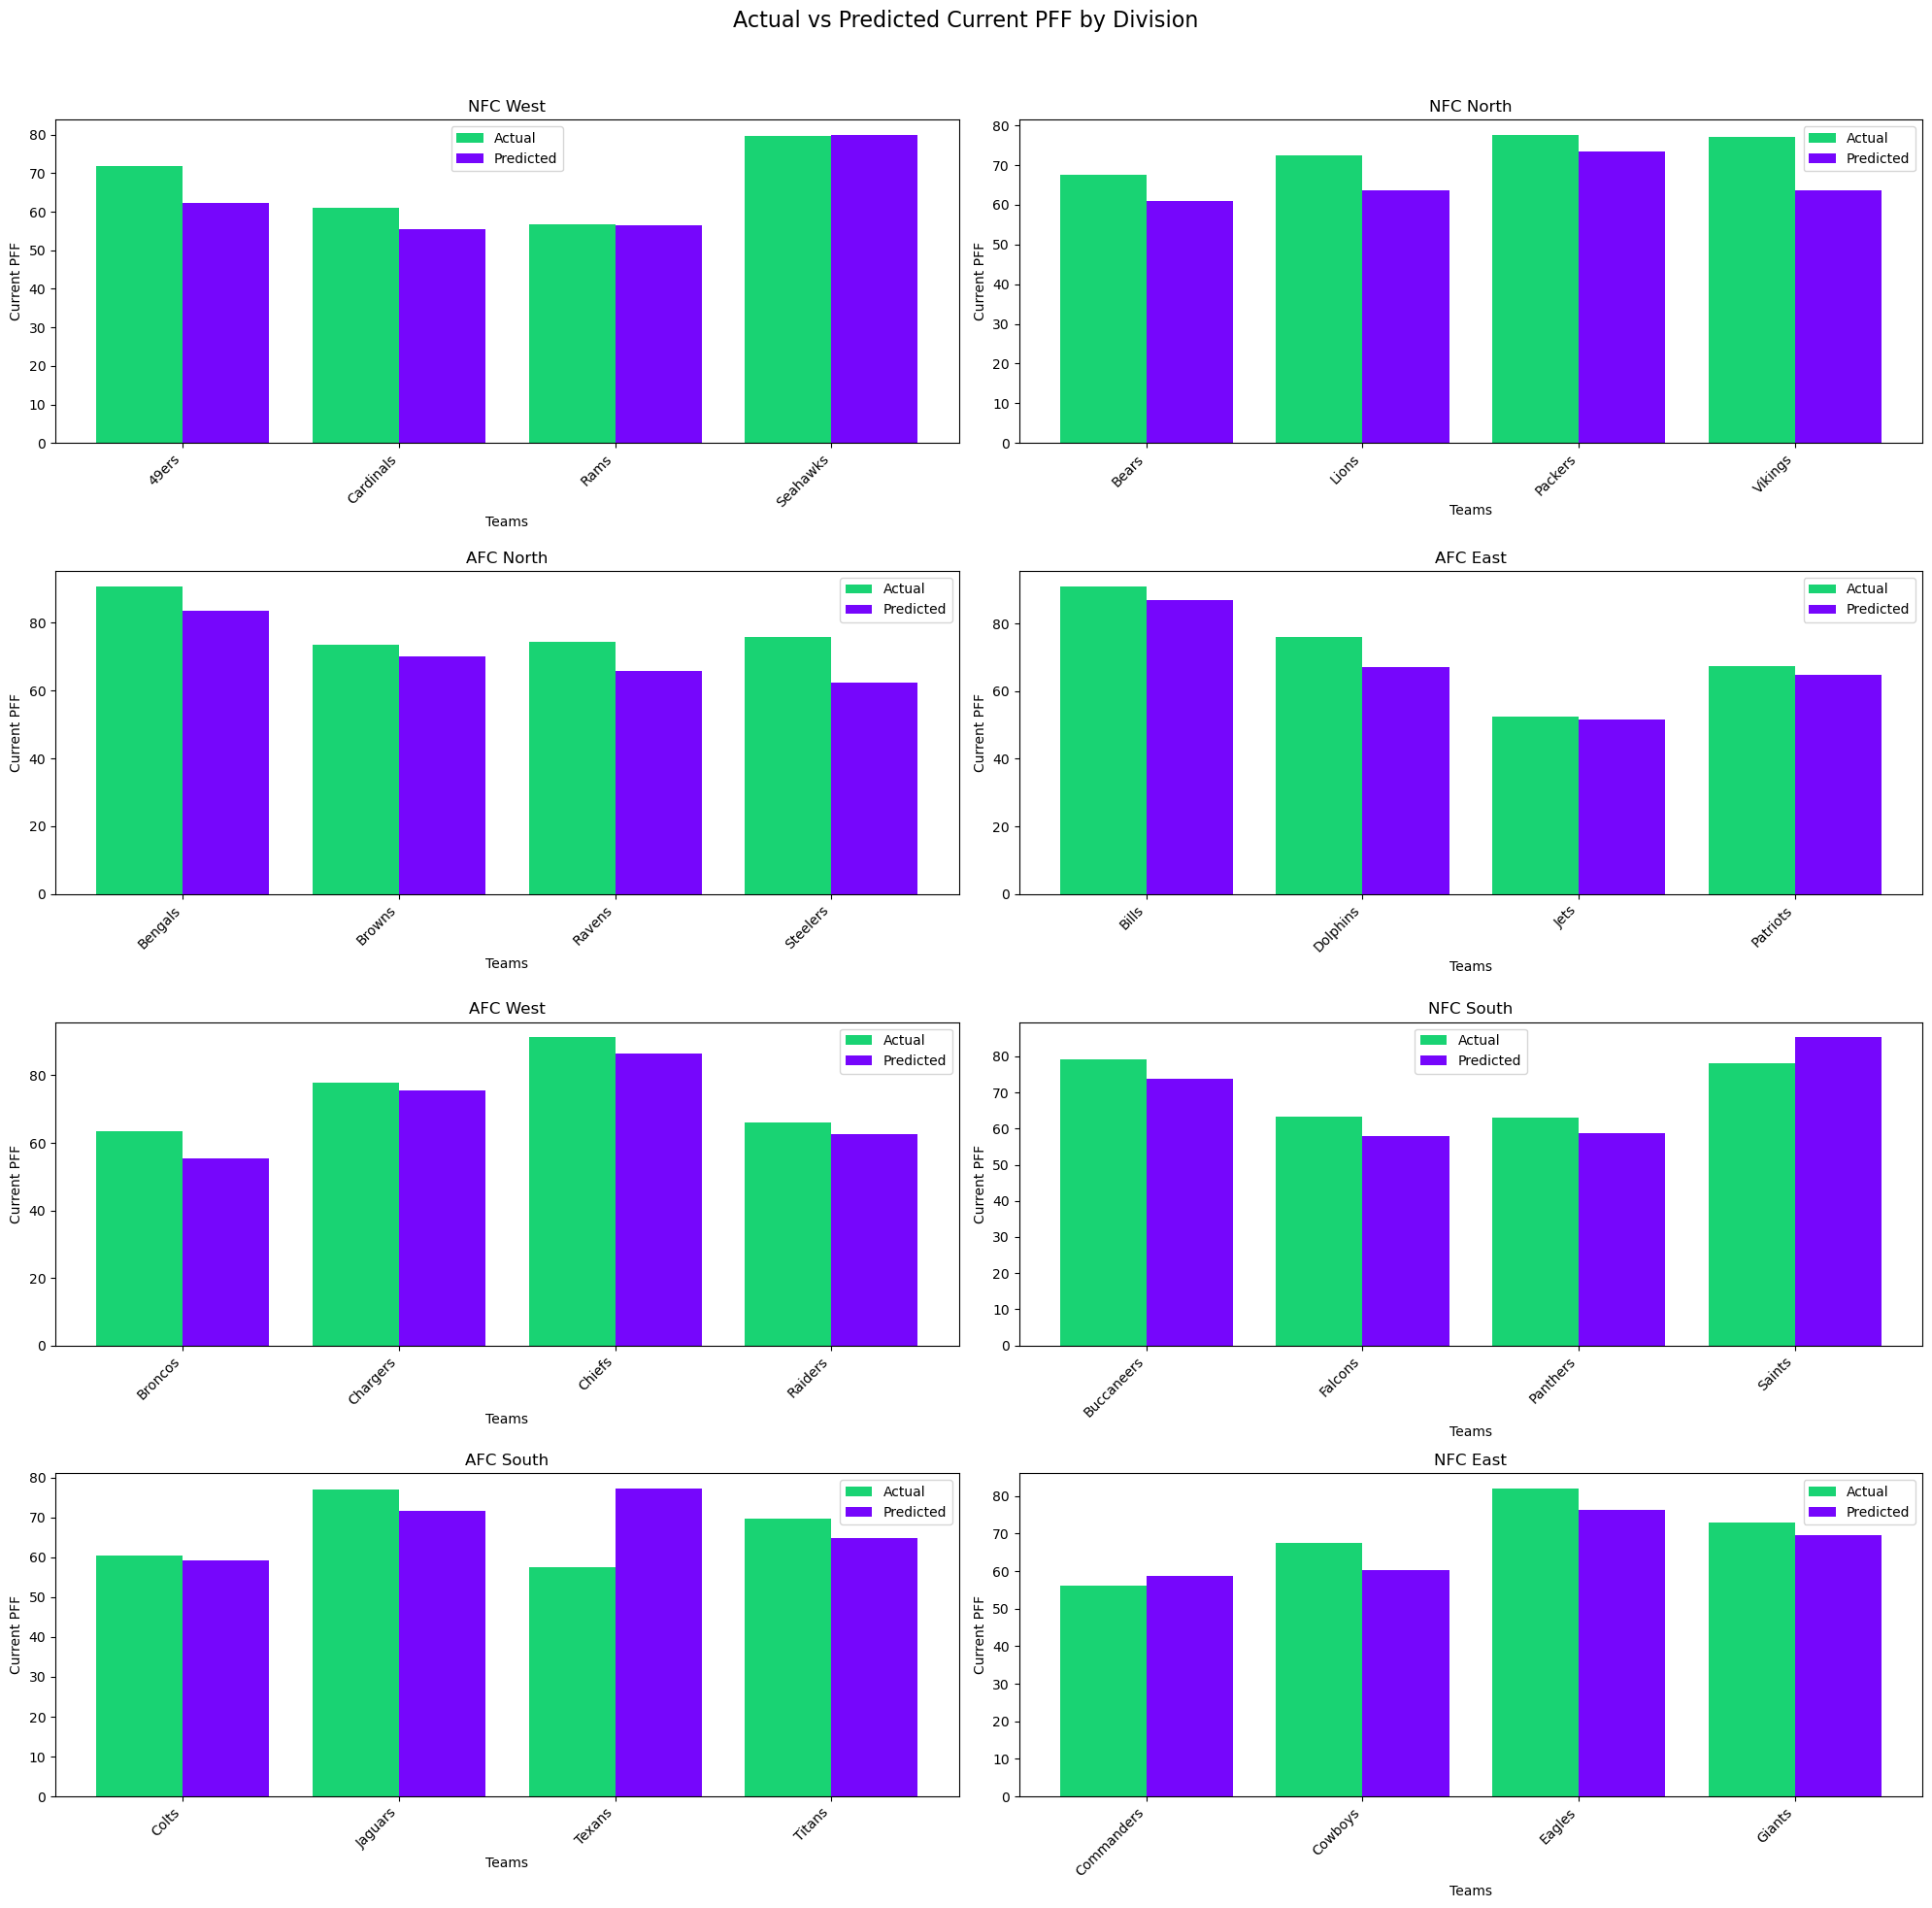

Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 73.9864 - val_loss: 134.3294
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 112.0399 - val_loss: 119.8352
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53.9207 - val_loss: 121.8812
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 111.3436 - val_loss: 128.2753
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51.8856 - val_loss: 140.3258
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 41.0306 - val_loss: 149.5728
Epoch 7/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 102.9238 - val_loss: 148.7404
Epoch 8/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 65.1646 - val_loss: 137.1976
Epoch 9/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70.6003 - val_loss: 135.2322
Epoch 10/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 59.5967 - val_loss: 137.4429
Epoch 11/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.0772 - val_loss: 138.2316
Epoch 12/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

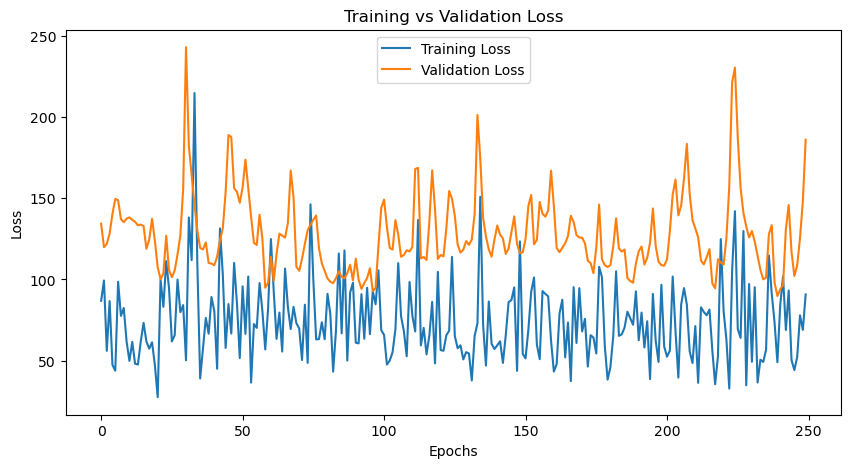

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
R² Score: 0.4797


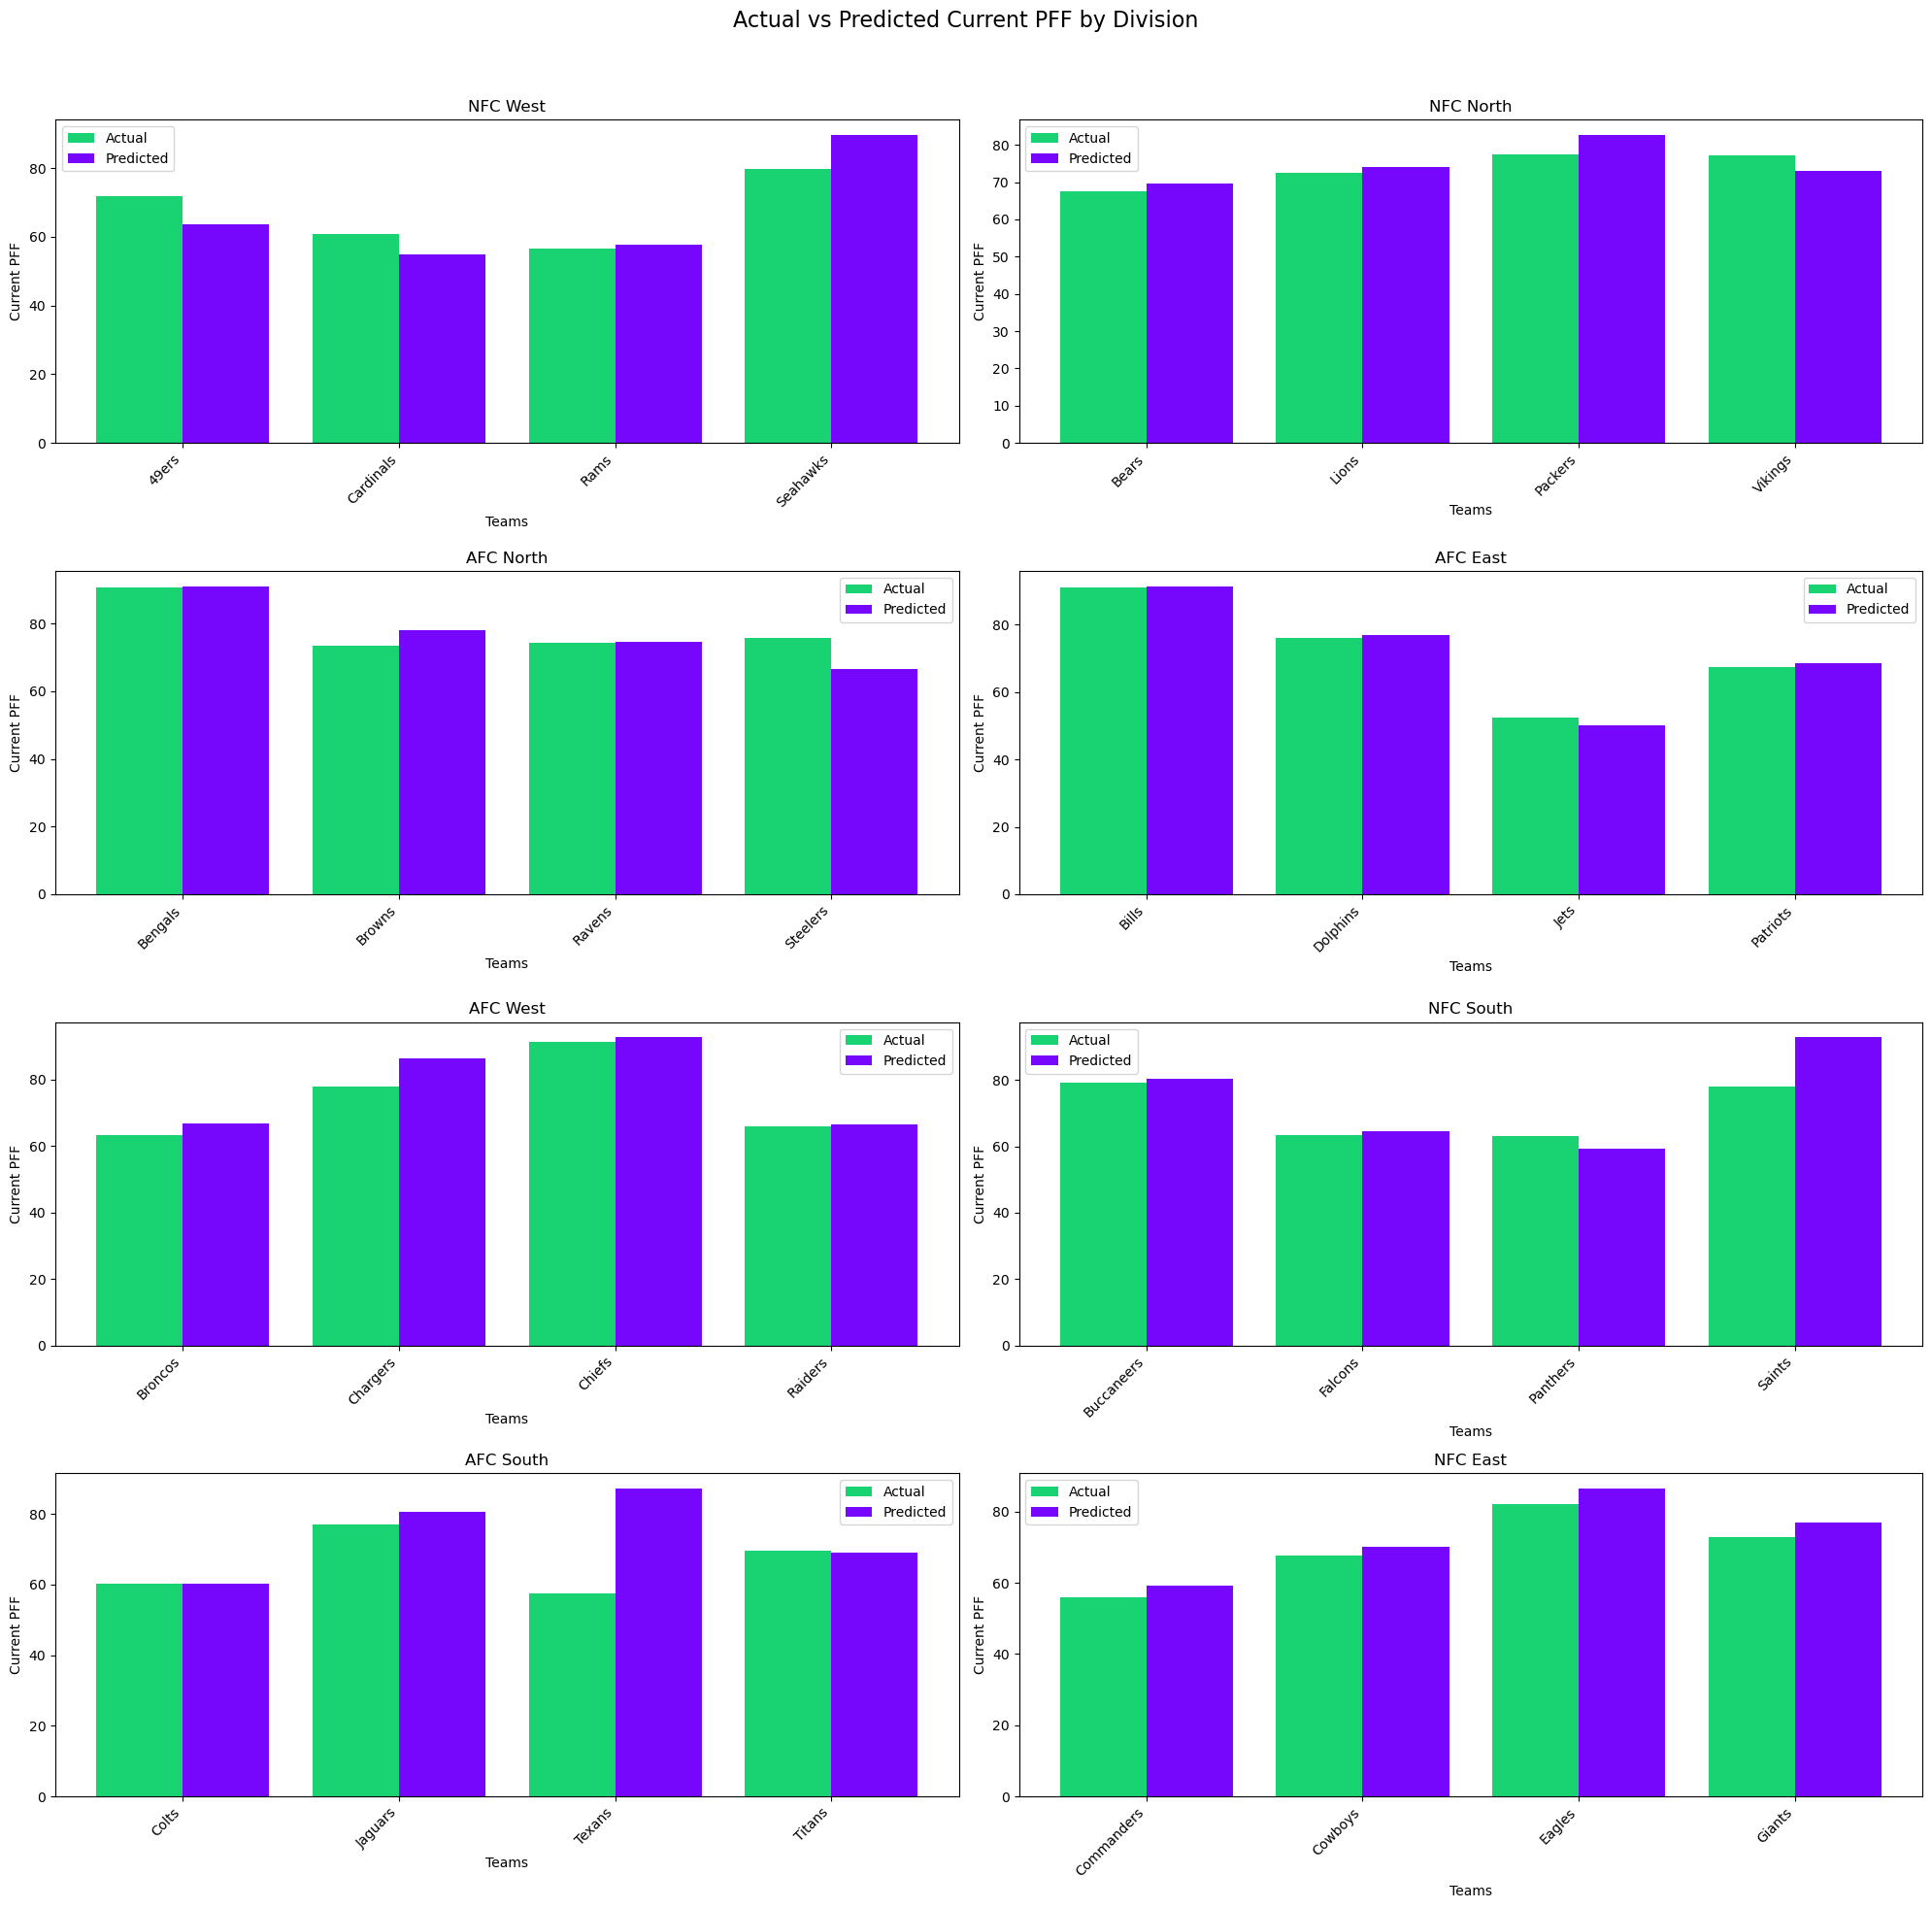

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 82.9886 - val_loss: 227.3499
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 141.5536 - val_loss: 187.0575
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 57.2637 - val_loss: 179.5560
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 106.0667 - val_loss: 176.1765
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52.4142 - val_loss: 174.8288
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 40.9995 - val_loss: 159.5408
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.6762 - val_loss: 165.4653
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 54.2623 - val_loss: 169.0232
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 79.0466 - val_loss: 179.7388
Epoch 10/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.6660 - val_loss: 157.2967
Epoch 11/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.5989 - val_loss: 144.1945
Epoch 12/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

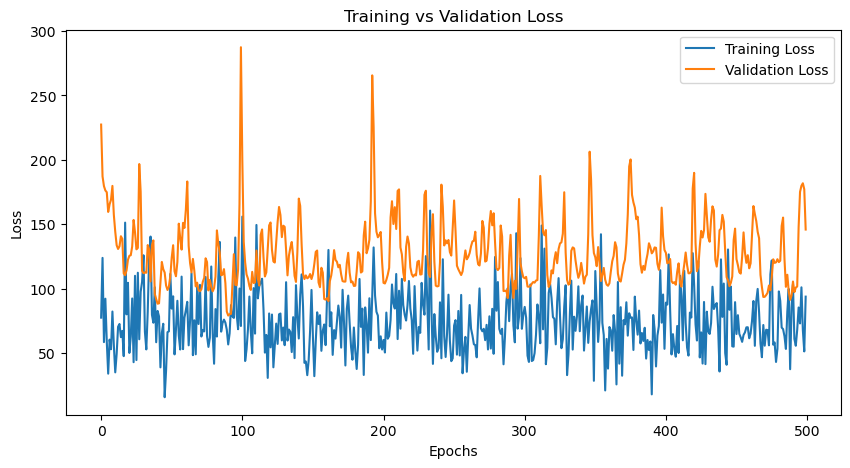

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
R² Score: 0.5853


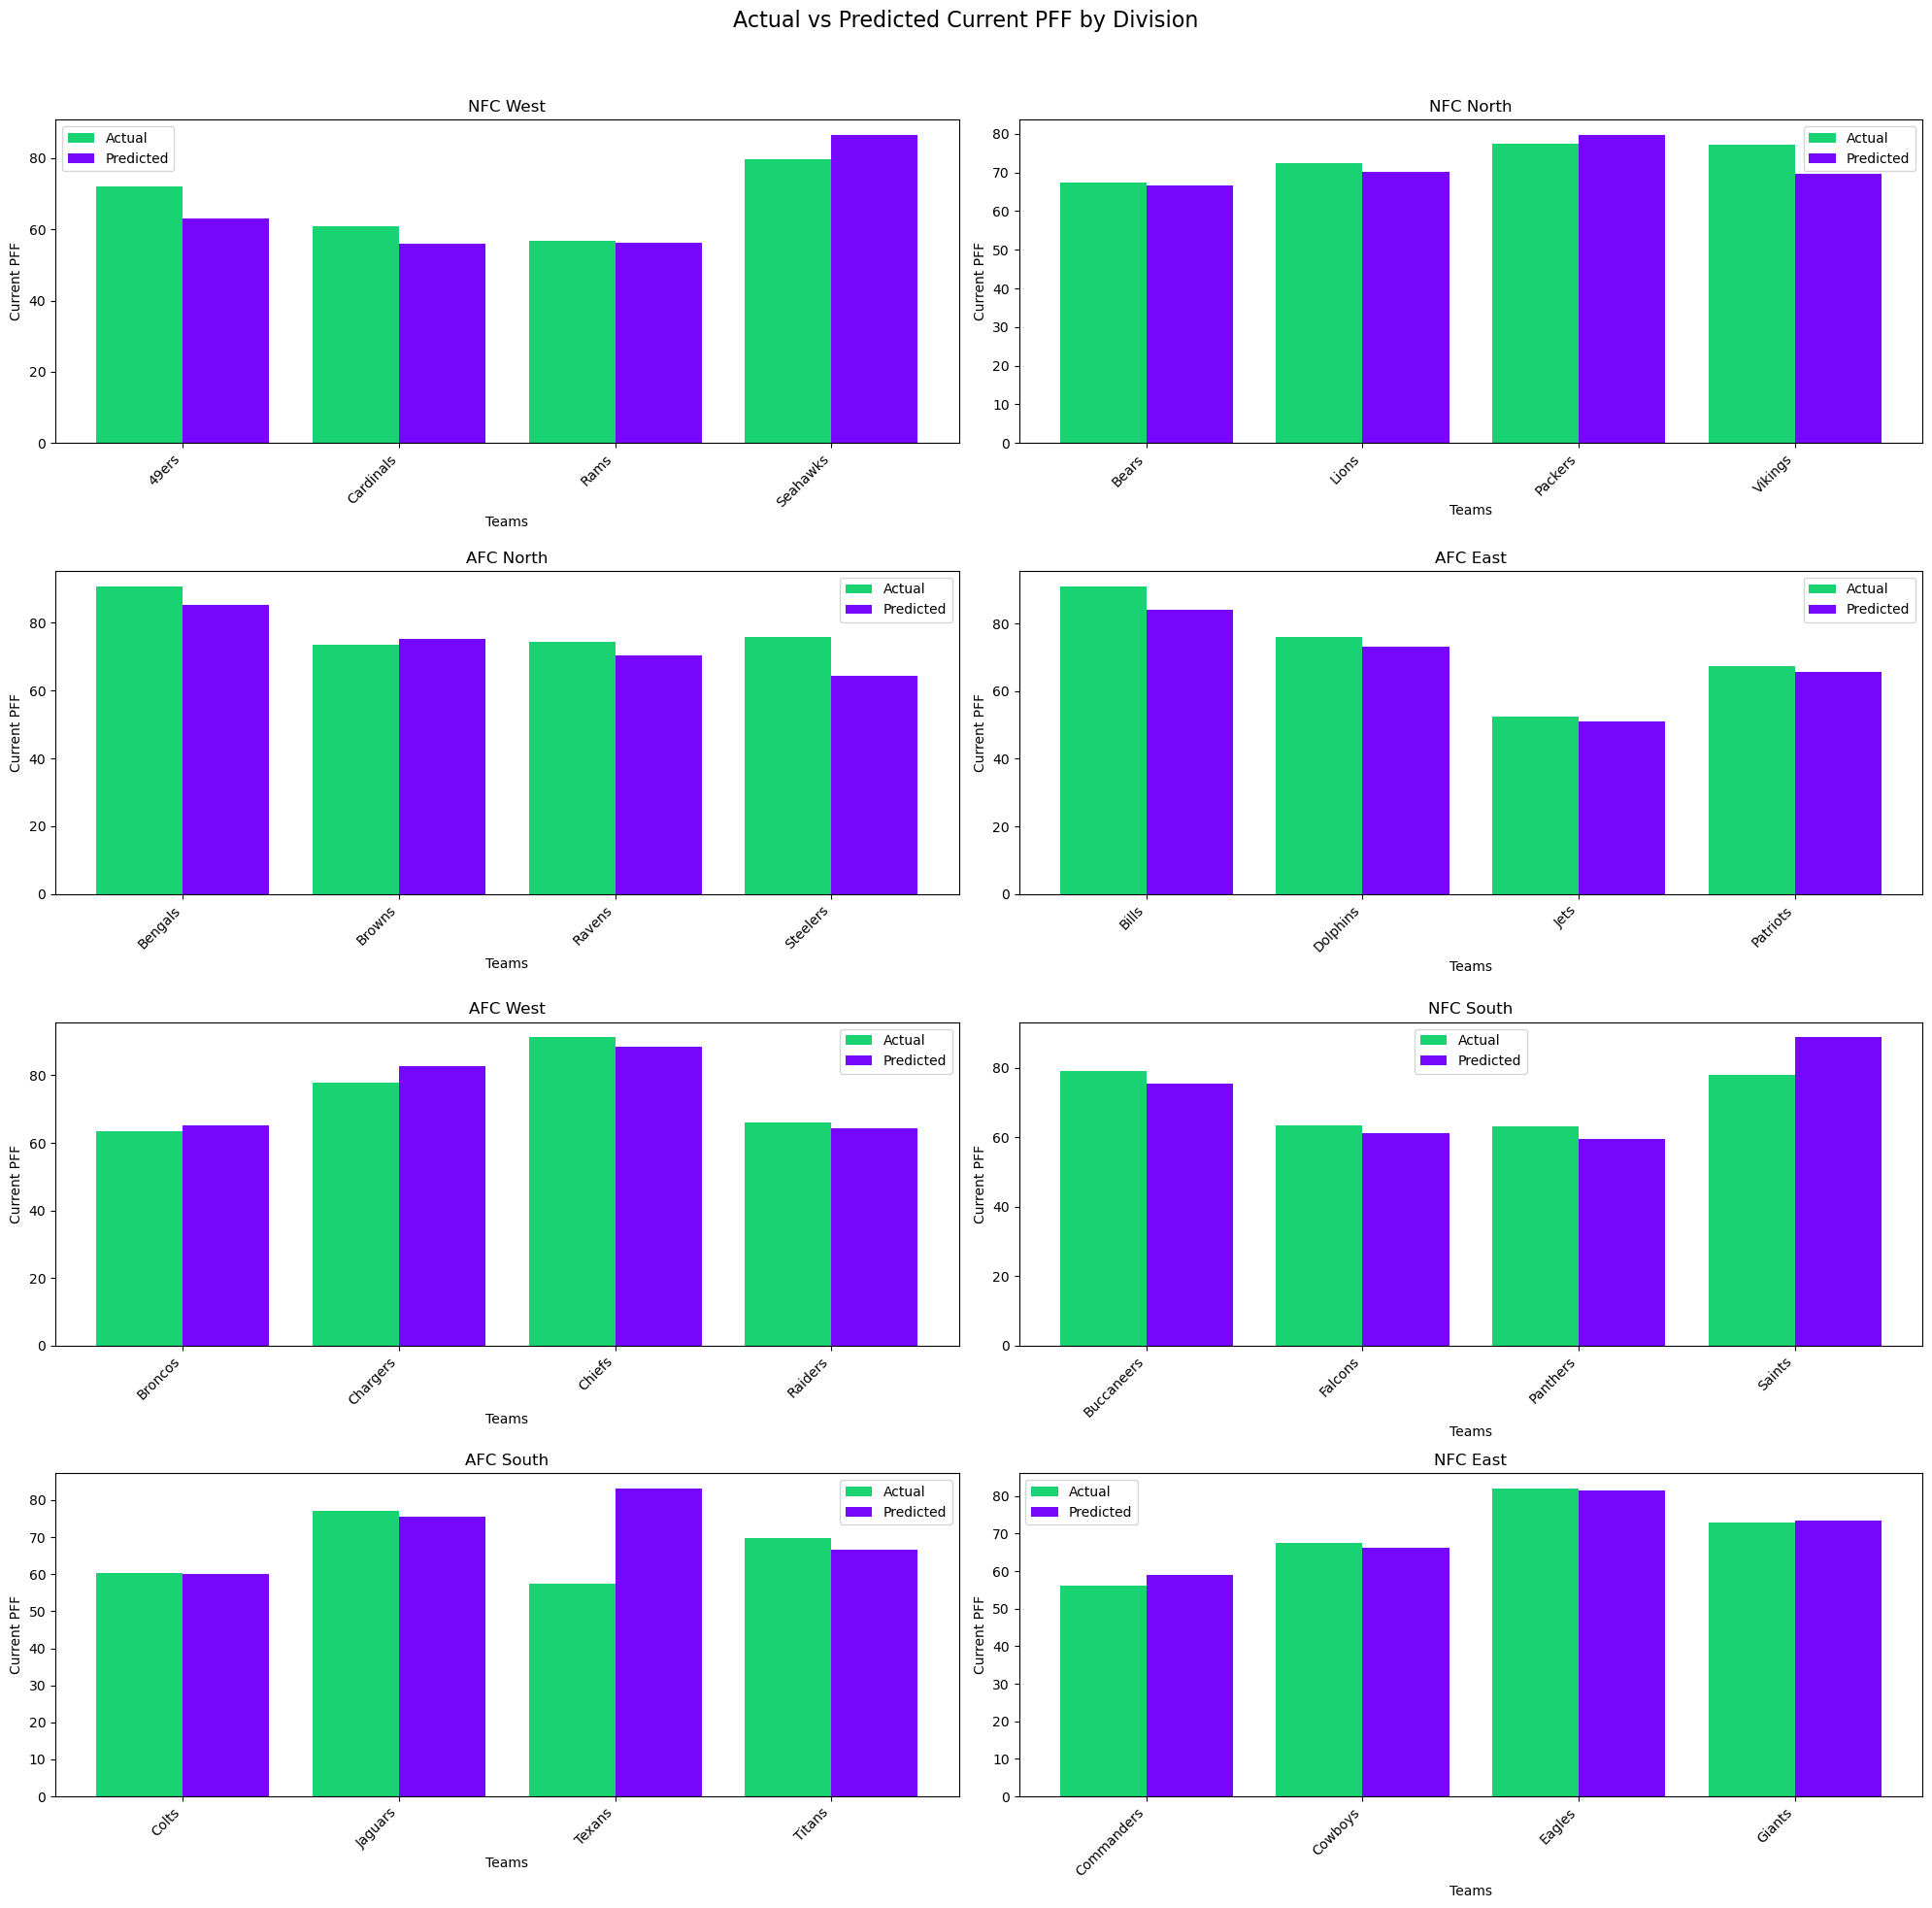

Epoch 1/750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 100.0019 - val_loss: 139.3049
Epoch 2/750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 63.5449 - val_loss: 186.2679
Epoch 3/750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 99.4814 - val_loss: 178.3914
Epoch 4/750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 94.3818 - val_loss: 123.7734
Epoch 5/750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 67.3738 - val_loss: 122.9448
Epoch 6/750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.2824 - val_loss: 118.1736
Epoch 7/750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 74.7559 - val_loss: 110.9977
Epoch 8/750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 83.5252 - val_loss: 114.8524
Epoch 9/750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 43.8287 - val_loss: 126.7632
Epoch 10/750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 62.0805 - val_loss: 120.3099
Epoch 11/750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 69.0956 - val_loss: 115.4311
Epoch 12/750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

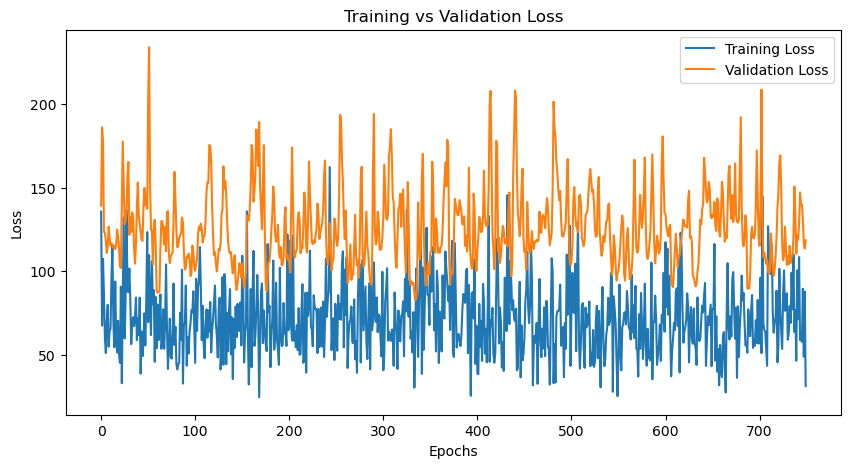

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
R² Score: 0.6755


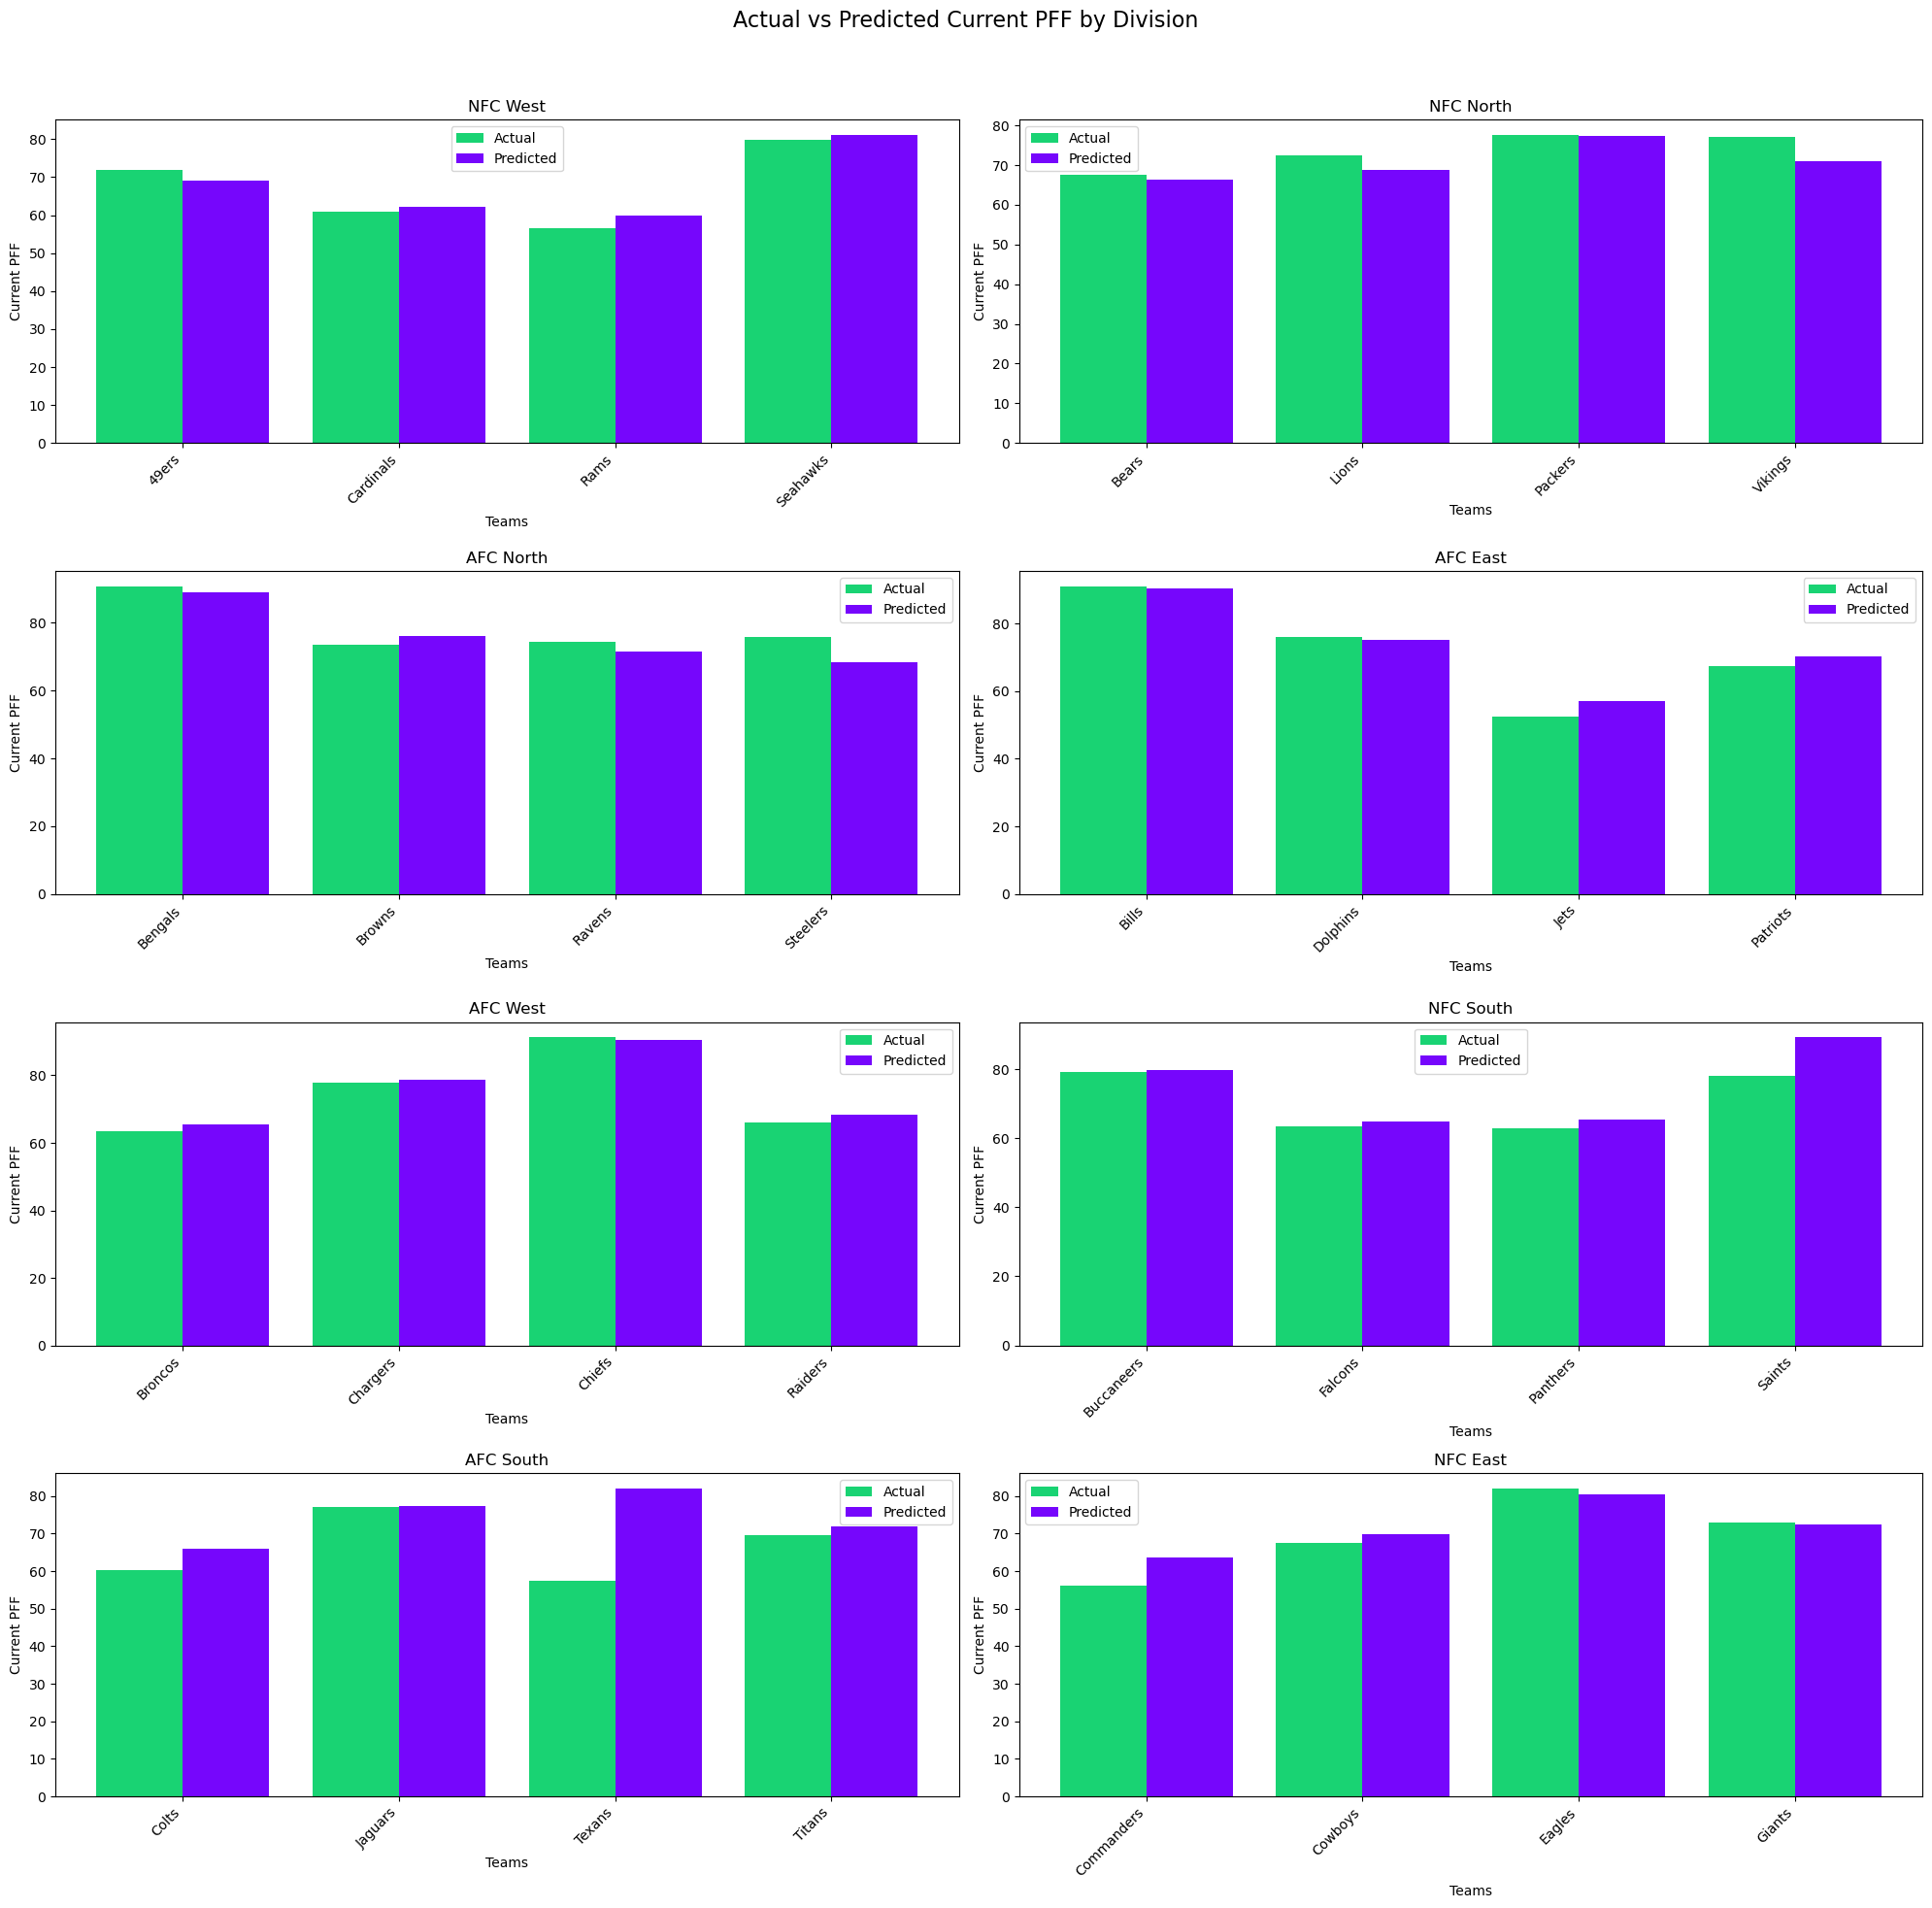

In [15]:
# Train the model
#history = model.fit(X, y, epochs=100, batch_size=8, validation_split=0.2, callbacks=[early_stopping])
epoch_list = [80, 100, 150, 200, 250, 500, 750]
for e in epoch_list:
    history = model.fit(X, y, epochs=e, batch_size=8, validation_split=0.2)
    # Plot training & validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # Make predictions on the test set
    y_pred = model.predict(X)
    from sklearn.metrics import r2_score

    # Calculate R² score
    r2 = r2_score(y, y_pred)

    # Print R² score
    print(f"R² Score: {r2:.4f}")
    # Plot actual vs predicted values
    data = df[df['Year'] == 2022].copy()
    data['Predicted_PFF'] = y_pred
    divisions = {
    "49ers": "NFC West", "Bears": "NFC North", "Bengals": "AFC North", "Bills": "AFC East",
    "Broncos": "AFC West", "Browns": "AFC North", "Buccaneers": "NFC South",
    "Cardinals": "NFC West", "Chargers": "AFC West", "Chiefs": "AFC West", "Colts": "AFC South",
    "Commanders": "NFC East", "Cowboys": "NFC East", "Dolphins": "AFC East", "Eagles": "NFC East",
    "Falcons": "NFC South", "Giants": "NFC East", "Jaguars": "AFC South", "Jets": "AFC East",
    "Lions": "NFC North", "Packers": "NFC North", "Panthers": "NFC South", "Patriots": "AFC East",
    "Raiders": "AFC West", "Rams": "NFC West", "Ravens": "AFC North", "Saints": "NFC South",
    "Seahawks": "NFC West", "Steelers": "AFC North", "Texans": "AFC South", "Titans": "AFC South",
    "Vikings": "NFC North"
}

    # Add the "Division" column
    data["Division"] = data["Team"].map(divisions)
    columns_to_keep = ['Current_PFF', 'Predicted_PFF', 'Team', 'Division']
    data = data.loc[:, columns_to_keep]
    
    divisions = data["Division"].unique()
    fig, axes = plt.subplots(4, 2, figsize=(20, 20))  # 4 rows, 2 columns

    for ax, division in zip(axes.flatten(), divisions):
        fig.suptitle('Actual vs Predicted Current PFF by Division', fontsize=16)
        division_data = data[data["Division"] == division]
        x = np.arange(4)  # Generate x-axis positions
        width = 0.4  # Bar width
        # Plot actual and predicted for this division
        ax.bar(x - width / 2, division_data['Current_PFF'], width, label='Actual', color='#19D373')  # Hex for Actual
        ax.bar(x + width / 2, division_data['Predicted_PFF'], width, label='Predicted', color='#7606FC')  # Hex for Predicted
        
        ax.set_xticks(x)
        ax.set_xticklabels(division_data['Team'], rotation=45, ha='right')
        ax.set_title(division)
        ax.set_xlabel('Teams')
        ax.set_ylabel('Current PFF')
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
    plt.show()
    
